<a href="https://colab.research.google.com/github/wlr2678/ChangE_4_data_playground/blob/master/first_glance_own_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
pip install pds4_tools
pip install matplotlib
pip install numpy
pip install Pillow
pip install colour-science
pip install colour-demosaicing

In [3]:
from pds4_tools import pds4_read       # to read and inspect the data and metadata
import matplotlib.pyplot as plt        # for plotting
import matplotlib
import numpy as np
from PIL import Image

import cv2 as cv # HDR tonemapping trial

# for plotting in Jupyter notebooks
# %matplotlib notebook
# for plotting in Google Colab, inline with the cell outputs
# %matplotlib inline

from skimage import exposure
from skimage import data, img_as_float
import colour
from colour.plotting import *
import glob

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007,
    mosaicing_CFA_Bayer)

cctf_encoding = colour.cctf_encoding
_ = colour.utilities.filter_warnings()
# colour.utilities.describe_environment();

In [4]:
def read_pds(path):
    data = pds4_read(path, quiet=True)
    img = np.array(data[0].data)
    img = img_as_float(img)
    return img

In [5]:
def debayer_img(img, CFA='RGGB'):
    # Menon2007 yields better edges than bilinear
    debayered = cctf_encoding(demosaicing_CFA_Bayer_Menon2007(img, CFA))
    return debayered

In [6]:
def stretch_img(img):
    # cf https://www.harrisgeospatial.com/docs/BackgroundStretchTypes.html
    # this is a 2 percent linear stretch
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img

In [7]:
def stretch_img_half(img):
    # cf https://www.harrisgeospatial.com/docs/BackgroundStretchTypes.html
    # this is a 0.5 percent linear stretch
    p1, p2 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p1, p2))
    return img

In [8]:
def plot_img_and_hist(image, ty='Q', size=10,  hist=True, bins=128): # ty indicates the type of the data product
    """Plot an image along with its histogram.
    """
    if hist:
        fig, axes = plt.subplots(2,1, figsize=(size,size), gridspec_kw={'height_ratios': [3, 1]})
        ax_img, ax_hist = axes
    else:
        fig, ax_img = plt.subplots(figsize=(size,size))

    # Display image
    ax_img.imshow(image, cmap='gray')
    ax_img.set_axis_off()

    if hist:
        # Display histogram
        if ty == 'Q': # Panchromatic
          ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
        elif ty == 'C': # Colour
          ax_hist.hist(image[:,:,0].ravel(), bins=bins, histtype='step', color='red')
          ax_hist.hist(image[:,:,1].ravel(), bins=bins, histtype='step', color='green')
          ax_hist.hist(image[:,:,2].ravel(), bins=bins, histtype='step', color='blue')
        else: # Unknown type
          print('Image data type not recognized')
          pass

        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])

In [9]:
  def check_type(p): # Check PCAM image type
    ty = p.split('_')[2].split('-')[1]
    print("Image type is:", ty)
    return ty

In [10]:
def export_img(name, img):
    pil_img = Image.fromarray(np.uint8(img*255))
    pil_img.save(name)
    print('Image exported.')

In [11]:
def preview_save(img, ty, size=10, hist=False):
  print('Generating preview...')
  plot_img_and_hist(img, ty, size, hist)
  plt.show()
  print('Saving image...')
  export_img('{}.png'.format(p), img)

Image size is: (1728, 2352)
Image type is: C
Performing normalization...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Generating preview...


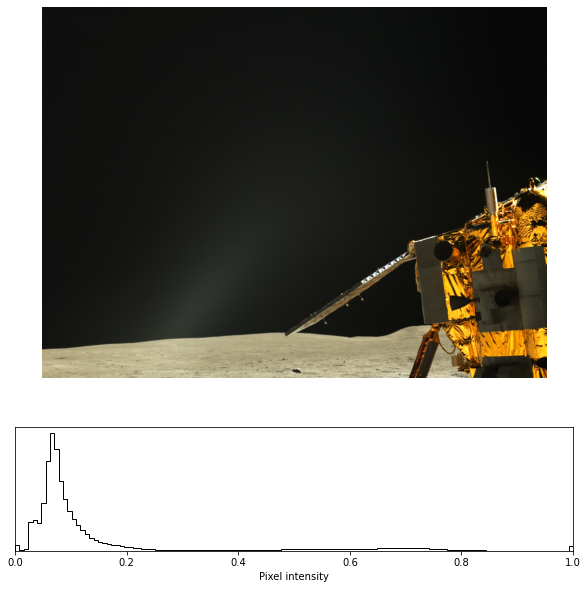

Saving image...
Image exported.


In [12]:
p = 'C:/Users/Darren Wu/Downloads/CE4_GRAS_PCAMR-C-000_SCI_N_20190104041502_20190104041502_0001_B.2BL'
img = read_pds(p)
print("Image size is:", img.shape)
ty = check_type(p)

if ty == 'C':
    img = debayer_img(img)

img = img.astype('float32')

'''
print(img[0])
print(img.dtype)
'''

tonemap1 = cv.createTonemapMantiuk(gamma=1, scale=0.8, saturation=1)
hdr_img = tonemap1.process(img)

'''
print(hdr_img[0])
print(hdr_img.dtype)
plot_img_and_hist(hdr_img, ty, 10, True)
'''

print('Performing normalization...')
hdr_img = stretch_img_half(hdr_img)
# print(hdr_img[0])
# print(hdr_img.dtype)

preview_save(hdr_img, ty, 10, True)